## IMPORTS

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("House_Rent_Dataset.csv")

In [413]:
data

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


### Exploratory Data Analysis

In [414]:
data['Tenant Preferred'].unique()

array(['Bachelors/Family', 'Bachelors', 'Family'], dtype=object)

In [415]:
data['Area Type'].unique()

array(['Super Area', 'Carpet Area', 'Built Area'], dtype=object)

In [416]:
data['Floor'].nunique()


480

In [417]:
data['Bathroom'].unique()

array([ 2,  1,  3,  5,  4,  6,  7, 10], dtype=int64)

<Axes: xlabel='Bathroom', ylabel='Rent'>

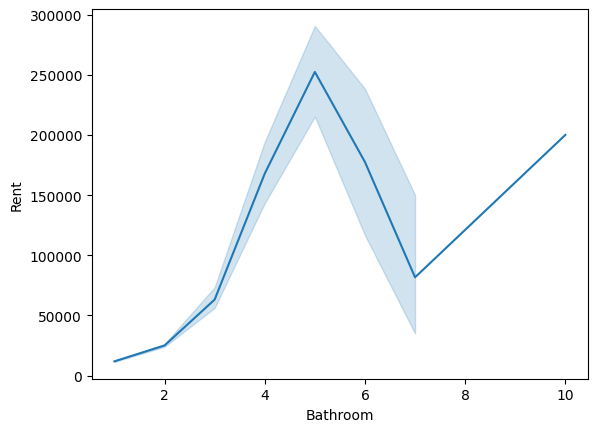

In [418]:
sns.lineplot(x='Bathroom', y='Rent', data=data)

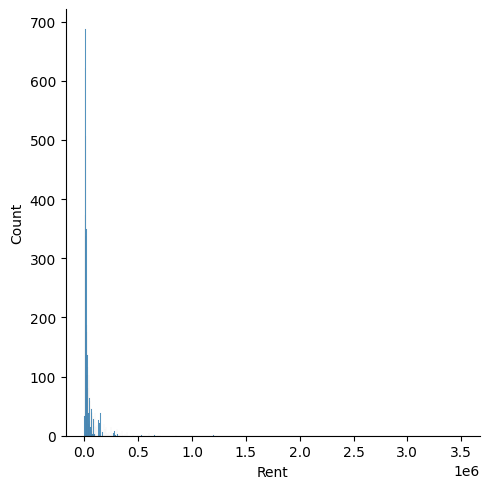

In [419]:
sns.displot(data['Rent'])

## Preprocessing

### Data Cleaning

In [420]:
data = data[['BHK',
             'Bathroom',
             'Furnishing Status',
             'Rent',
             'Size',
             'Floor',
             'Area Type',
             'Tenant Preferred',
             'Point of Contact',
             #'Area Locality',
             'City'
             ]]

#### Removing Rent Outliers

In [421]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[ (data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

data = remove_outliers(data, 'Rent')
#data = remove_outliers(data, 'BHK')
data = remove_outliers(data, 'Bathroom')
data = remove_outliers(data, 'Size')

### Addressing Floor Column

In [422]:


data[['CurrentFloor', 'TotalFloors']] = data['Floor'].str.split(' out of ', expand=True)

data['CurrentFloor'] = data['CurrentFloor'].replace("Ground", 1)
data['CurrentFloor'] = data['CurrentFloor'].replace("Upper Basement", 0)
data['CurrentFloor'] = data['CurrentFloor'].replace("Lower Basement", -1)

data['CurrentFloor'] = pd.to_numeric(data['CurrentFloor'])
data['TotalFloors'] = pd.to_numeric(data['TotalFloors'])
data['CurrentFloor'] = data['CurrentFloor'] + 2
data['TotalFloors'] = data['TotalFloors'] + 2

data.dropna(inplace=True)


data.drop('Floor', axis=1, inplace=True)

#data['Floor'] = data['CurrentFloor'] / data['TotalFloors']
#data.drop(['CurrentFloor', 'TotalFloors'], axis=1, inplace=True) 


In [423]:
data

,BHK,Bathroom,Furnishing Status,Rent,Size,Floor,Area Type,Tenant Preferred,Point of Contact,City
0,2,2,Unfurnished,10000,1100,0.750000,Super Area,Bachelors/Family,Contact Owner,Kolkata
1,2,1,Semi-Furnished,20000,800,0.600000,Super Area,Bachelors/Family,Contact Owner,Kolkata
2,2,1,Semi-Furnished,17000,1000,0.600000,Super Area,Bachelors/Family,Contact Owner,Kolkata
3,2,1,Unfurnished,10000,800,0.750000,Super Area,Bachelors/Family,Contact Owner,Kolkata
4,2,1,Unfurnished,7500,850,0.750000,Carpet Area,Bachelors,Contact Owner,Kolkata
...,...,...,...,...,...,...,...,...,...,...
4740,2,2,Unfurnished,12000,1350,1.000000,Super Area,Bachelors/Family,Contact Owner,Hyderabad
4741,2,2,Semi-Furnished,15000,1000,0.714286,Carpet Area,Bachelors/Family,Contact Owner,Hyderabad
4743,3,3,Semi-Furnished,35000,1750,0.714286,Carpet Area,Bachelors/Family,Contact Agent,Hyderabad
4744,3,2,Semi-Furnished,45000,1500,0.694444,Carpet Area,Family,Contact Agent,Hyderabad


### Encoding

In [424]:
def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

data = one_hot_encode(data, 'Furnishing Status')
data = one_hot_encode(data, 'Tenant Preferred')
data = one_hot_encode(data, 'Point of Contact')
data = one_hot_encode(data, 'Area Type')
data = one_hot_encode(data, 'City')

### Train/Test Splitting

In [425]:
X = data.drop('Rent', axis= 1)
y = data['Rent']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20 , random_state = 42)

### Standardization

In [426]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [427]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)


In [428]:
data

,BHK,Bathroom,Rent,Size,Floor,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Builder,Contact Owner,Carpet Area,Super Area,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
0,2,2,10000,1100,0.750000,False,True,True,False,False,True,False,True,False,False,False,True,False
1,2,1,20000,800,0.600000,True,False,True,False,False,True,False,True,False,False,False,True,False
2,2,1,17000,1000,0.600000,True,False,True,False,False,True,False,True,False,False,False,True,False
3,2,1,10000,800,0.750000,False,True,True,False,False,True,False,True,False,False,False,True,False
4,2,1,7500,850,0.750000,False,True,False,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,2,2,12000,1350,1.000000,False,True,True,False,False,True,False,True,False,False,True,False,False
4741,2,2,15000,1000,0.714286,True,False,True,False,False,True,True,False,False,False,True,False,False
4743,3,3,35000,1750,0.714286,True,False,True,False,False,False,True,False,False,False,True,False,False
4744,3,2,45000,1500,0.694444,True,False,False,True,False,False,True,False,False,False,True,False,False


## Modelling

In [429]:
# from sklearn.linear_model import ElasticNet
# from sklearn.metrics import mean_squared_error, r2_score

# # Create an instance of the ElasticNet model
# elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5)

# # Fit the model to the training data
# elastic_net.fit(X_train, y_train)

# # Predict on the test data
# y_preds = elastic_net.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_preds)
# r2 = r2_score(y_test, y_preds)

# print("Mean Squared Error: %.2f" % mse)
# print("Coefficient of Determination: %.2f" % r2)


In [430]:
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
model = linear_model.LinearRegression()
model = RidgeCV(alphas=[0.1, 1, 10, 100])
model = LassoCV(cv=5)
model.fit(X_train, y_train)
model.coef_


array([ 0.00000000e+00,  2.12783609e+03,  1.37877446e+03,  3.76587102e+03,
       -3.40414077e+02, -0.00000000e+00, -3.25146825e+02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  2.22514699e+02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  4.68592959e+02,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.80947643e+02, -0.00000000e+00,  0.00000000e+00, -1.43613733e+02,
        0.00000000e+00, -0.00000000e+00, -3.88080112e+01, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -2.36881633e+02,  0.00000000e+00, -5.42106950e+02,
        0.00000000e+00, -0.00000000e+00, -2.38402630e+01,  6.19016059e+02,
       -8.36967856e+01,  0.00000000e+00, -0.00000000e+00,  6.00582031e+02,
       -1.42750390e+02, -

# Evaluation

In [431]:
y_preds = model.predict(X_test)

In [432]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds))

Coefficients: 
 [ 0.00000000e+00  2.12783609e+03  1.37877446e+03  3.76587102e+03
 -3.40414077e+02 -0.00000000e+00 -3.25146825e+02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  2.22514699e+02
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  4.68592959e+02
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.80947643e+02 -0.00000000e+00  0.00000000e+00 -1.43613733e+02
  0.00000000e+00 -0.00000000e+00 -3.88080112e+01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -2.36881633e+02  0.00000000e+00 -5.42106950e+02
  0.00000000e+00 -0.00000000e+00 -2.38402630e+01  6.19016059e+02
 -8.36967856e+01  0.00000000e+00 -0.00000000e+00  6.00582031e+02
 -1.42750390e+02 -0.00000000e+00 -1.39725618e+02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.17830895e+02 -0.00000000e+00
  0.00000

In [433]:
train_r2 = model.score(X_train, y_train)
print("Training Coefficient of Determination: %.2f" % train_r2)


Training Coefficient of Determination: 0.74


### Qualitative Evaluation

In [434]:
sample_data = X.iloc[0]
sample_data

BHK                     2
Bathroom                2
Size                 1100
Floor                0.75
Semi-Furnished      False
Unfurnished          True
Bachelors/Family     True
Family              False
Contact Builder     False
Contact Owner        True
Carpet Area         False
Super Area           True
Chennai             False
Delhi               False
Hyderabad           False
Kolkata              True
Mumbai              False
Name: 0, dtype: object

In [435]:
sample_data_standardized = poly.transform(X.iloc[0].values.reshape(1,-1))

In [436]:
model_rent_forecast = model.predict(sample_data_standardized)[0]
model_rent_forecast

729918514.2377032

In [437]:
y.iloc[0]

10000

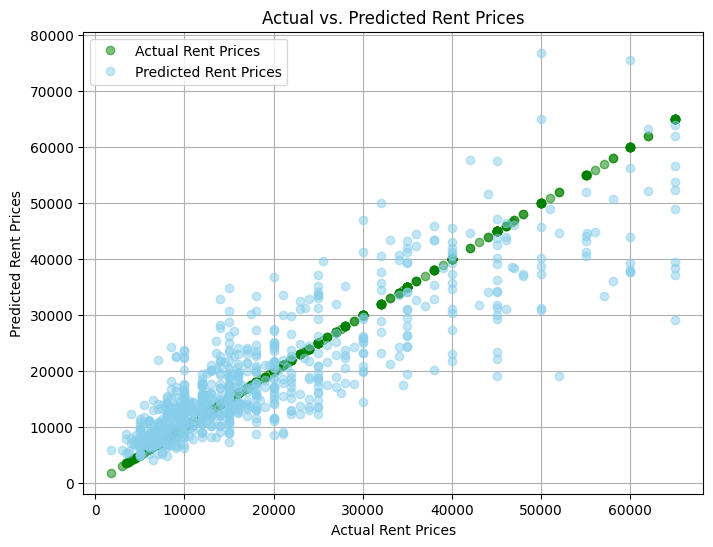

In [438]:
plt.figure(figsize=(8,6))
plt.plot(y_test, y_test, 'o', alpha=0.5, color='green', label='Actual Rent Prices')
plt.plot(y_test, y_preds, 'o', alpha=0.5, color='skyblue', label='Predicted Rent Prices')

plt.title("Actual vs. Predicted Rent Prices")
plt.xlabel("Actual Rent Prices")
plt.ylabel("Predicted Rent Prices")

plt.legend()
plt.grid(True)
plt.show()